In [2]:
import pathlib
import keras
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the paths to your training, validation and test datasets
training_dir = '/content/drive/MyDrive/Bahan Makanan'
validation_dir = '/content/drive/MyDrive/Bahan Makanan'
test_dir = '/content/drive/MyDrive/Bahan Makanan'

In [4]:
# We can check image shape using this code
import cv2
import numpy as np

# Load the image
image = cv2.imread('/content/drive/MyDrive/Bahan Makanan/Ayam/daging ayam (1).jpeg')

# Check the shape of the image
height, width, channels = image.shape
# Dataset comprises of images of shape: (150,150,3)
# Print the image shape
print(f"Image shape: (height={height}, width={width}, channels={channels})")

Image shape: (height=318, width=475, channels=3)


In [5]:
# Define data augmentation for training
datagen = ImageDataGenerator(
    rescale=1./255,
)


# Data Generation for train, validation and Test
train_generator = datagen.flow_from_directory(
    training_dir,
    target_size=(128,128),
    batch_size=32,
    shuffle = True,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
    )
val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(128,128),
    batch_size=32,
    shuffle = True,
    class_mode='categorical'
)
test_datagen = ImageDataGenerator(
    rescale=1./255
    )
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128,128),
    batch_size=32,
    shuffle = True,
    class_mode='categorical'
)

Found 15519 images belonging to 15 classes.
Found 15519 images belonging to 15 classes.
Found 15519 images belonging to 15 classes.


In [6]:
from sklearn.model_selection import train_test_split

# Misalkan 'data' adalah data Anda tanpa label
data = '/content/drive/MyDrive/Bahan Makanan'  # Sesuaikan dengan data Anda

# Pisahkan data menjadi train (80%), validation (10%), dan test (10%)
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Output ukuran set data
print("Jumlah data pelatihan:", len(train_data))
print("Jumlah data validasi:", len(validation_data))
print("Jumlah data uji:", len(test_data))


Jumlah data pelatihan: 28
Jumlah data validasi: 4
Jumlah data uji: 4


In [7]:
import numpy as np

# Simpan data pelatihan, validasi, dan uji ke dalam file
np.save('train_data.npy', train_data)
np.save('validation_data.npy', validation_data)
np.save('test_data.npy', test_data)

In [8]:
# Data Augmentation can also be applied using ImageDataGenerator but this method of applying augmentation in layer is more efficient in GPU usage
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
    ])

In [9]:
# Model Architecture
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128,128, 3))

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(128,128, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(15, activation='softmax')(x)  # Adjust NUM_CLASSES to your task

model = Model(inputs, predictions)


58889256/58889256 [==============================] - 3s 0us/step


In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, None, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                              

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    verbose=1
)

Epoch 1/15
485/485 [==============================] - 10239s 21s/step - loss: 0.9059 - accuracy: 0.7288 - val_loss: 0.4847 - val_accuracy: 0.8598
Epoch 2/15
485/485 [==============================] - 115s 237ms/step - loss: 0.5440 - accuracy: 0.8389 - val_loss: 0.4130 - val_accuracy: 0.8714
Epoch 3/15
485/485 [==============================] - 119s 246ms/step - loss: 0.4774 - accuracy: 0.8526 - val_loss: 0.3617 - val_accuracy: 0.8895
Epoch 4/15
485/485 [==============================] - 121s 249ms/step - loss: 0.4588 - accuracy: 0.8604 - val_loss: 0.3068 - val_accuracy: 0.9080
Epoch 5/15
485/485 [==============================] - 118s 244ms/step - loss: 0.4296 - accuracy: 0.8667 - val_loss: 0.3118 - val_accuracy: 0.9073
Epoch 6/15
485/485 [==============================] - 116s 239ms/step - loss: 0.4208 - accuracy: 0.8728 - val_loss: 0.3218 - val_accuracy: 0.8992
Epoch 7/15
485/485 [==============================] - 141s 290ms/step - loss: 0.4106 - accuracy: 0.8761 - val_loss: 0.2904 -

In [1]:
# Training and Validation Accuracy plot
import matplotlib.pyplot as plt

# Define needed variables
tr_acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]

acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (12, 5))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

NameError: ignored

In [ ]:
#Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [ ]:
## Fine tuning to improve accuracy
base_model.trainable = True


custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

# Compile the model
model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = keras.callbacks.EarlyStopping( monitor='val_accuracy',patience=5,restore_best_weights=True)

# Train the model with fine-tuning
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    )

Epoch 1/20
485/485 [==============================] - 216s 425ms/step - loss: 0.2682 - accuracy: 0.9193 - val_loss: 0.1175 - val_accuracy: 0.9649
Epoch 2/20
485/485 [==============================] - 134s 277ms/step - loss: 0.1568 - accuracy: 0.9536 - val_loss: 0.0932 - val_accuracy: 0.9724
Epoch 3/20
485/485 [==============================] - 138s 285ms/step - loss: 0.1142 - accuracy: 0.9655 - val_loss: 0.0685 - val_accuracy: 0.9793
Epoch 4/20
485/485 [==============================] - 132s 273ms/step - loss: 0.0931 - accuracy: 0.9739 - val_loss: 0.0389 - val_accuracy: 0.9884
Epoch 5/20
485/485 [==============================] - 133s 274ms/step - loss: 0.0727 - accuracy: 0.9796 - val_loss: 0.0429 - val_accuracy: 0.9861
Epoch 6/20
485/485 [==============================] - 134s 277ms/step - loss: 0.0623 - accuracy: 0.9836 - val_loss: 0.0374 - val_accuracy: 0.9889
Epoch 7/20
485/485 [==============================] - 161s 332ms/step - loss: 0.0532 - accuracy: 0.9855 - val_loss: 0.0297 -

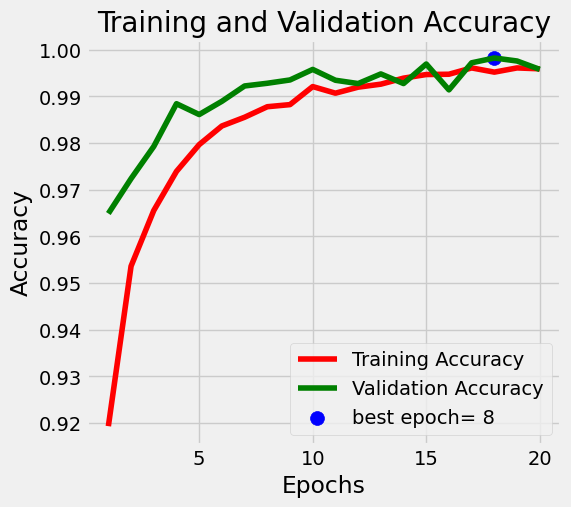

In [ ]:
# Training and Validation Accuracy plot

# Define needed variables
tr_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]

# Plot training history
plt.figure(figsize= (12, 5))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 100, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
loss, accuracy = model.evaluate(val_generator)
print(f'Test loss: {loss:.4f}, accuracy: {accuracy:.4f}')

485/485 [==============================] - 55s 114ms/step - loss: 0.0183 - accuracy: 0.9957
Test loss: 0.0183, accuracy: 0.9957


In [ ]:
from sklearn.metrics import classification_report, f1_score
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis = 1)

485/485 [==============================] - 59s 121ms/step


In [ ]:
import pandas as pd

classes = dict(zip(val_generator.class_indices.values(), val_generator.class_indices.keys()))
Predictions = pd.DataFrame({
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(val_generator), axis = 1))]
                           })
Predictions.head(1595)

485/485 [==============================] - 56s 116ms/step


,Prediction Labels,Prediction Classes,Prediction Probability
0,7,Daun Bawang,0.987478
1,7,Daun Bawang,0.999782
2,13,Terong,0.993709
3,8,Kentang,0.991443
4,14,Wortel,0.999923
...,...,...,...
1590,2,Bawang Putih,0.948482
1591,5,Cabe,1.000000
1592,13,Terong,0.993322
1593,1,Bawang Merah,0.999982


from matplotlib import pyplot as plt
_df_0['Prediction Labels'].plot(kind='hist', bins=20, title='Prediction Labels')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Prediction Probability'].plot(kind='hist', bins=20, title='Prediction Probability')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Prediction Labels', y='Prediction Probability', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Prediction Labels'].plot(kind='line', figsize=(8, 4), title='Prediction Labels')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Prediction Probability'].plot(kind='line', figsize=(8, 4), title='Prediction Probability')
plt.gca().spines[['top', 'right']].set_visible(False)

# **Save to TFLite**


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
  f.write(tflite_model)


# **Save to H5**

In [ ]:
from tensorflow.keras.models import load_model, save_model
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
from IPython.display import display
from ipywidgets import FileUpload
import io

# Memuat model dari file
model = load_model('model.h5')

# Membuat widget unggahan file
uploader = FileUpload()
display(uploader)

def on_upload(change):
    # Mendapatkan konten file yang diunggah
    content = next(iter(uploader.value.values()))['content']

    # Membaca gambar dari konten
    img = image.load_img(io.BytesIO(content), target_size=(128,128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalisasi

    # Membuat prediksi
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)
    print(f'Predicted class: {predicted_class}')

# Mendengarkan perubahan pada widget unggahan
uploader.observe(on_upload, names='_counter')


OSError: ignored